# Multiple object recognition with visual attention

In this notebook, I implement the model from Ba et al. "Multiple object recognition with visual attention"

In [1]:
from __future__ import division
from __future__ import absolute_import
from __future__ import print_function

import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials import mnist
from tensorflow.python.ops import array_ops

In [2]:
class mnist_provider(object):
  """MNIST data provider."""
  def __init__(self, data_directory, split="train"):
    mnist_data = mnist.input_data.read_data_sets(data_directory, one_hot=True)
    if split == "train":
      self.mnist_data = mnist_data.train
    elif split == "valid":
      self.mnist_data = mnist_data.validation
    elif split == "test":
      self.mnist_data = mnist_data.test

  def next_batch(self, batch_size):
    images, one_hot_labels = self.mnist_data.next_batch(batch_size)
    images = np.reshape(images, [-1, 28, 28, 1], order='C')
    return images, one_hot_labels

In [15]:
class GlimpseNet(object):
  """Glimpse network.
  
  "The glimpse network is a non-linear function that receives the current input image
  patch, or glimpse, xn and its location tuple ln , where ln = (xn, yn), as input and 
  outputs a vector gn"
  """
  def __init__(self, 
               layers_size=(
                 (3, 3, 1, 64),
                 (3, 3, 64, 64),
                 (3, 3, 64, 64),
                 (16 * 16 * 64, 128)
               )):
    """ 
    
    Args:
      layers_size: layer sizes (tuple of shape tuples).
        default:
          layer 1: 3x3 conv, input with 1 color channel, 64 channels output
          layer 2: 3x3 conv, 64 channels output
          layer 3: 3x3 conv, 64 channels output
          layer 4: fully connected, input with size 16x16, output size 128
    
    """
    
    self.params = {}
    with tf.variable_scope("glimpse_net"):
      self.params["W_conv1"] = tf.get_variable(name="W_conv1", shape=layers_size[0],
                          initializer=tf.truncated_normal_initializer(stddev=0.1))
      self.params["b_conv1"] = tf.get_variable(name="b_conv1", shape=layers_size[0][-1],
                          initializer=tf.zeros_initializer())
      
      self.params["W_conv2"] = tf.get_variable(name="W_conv2", shape=layers_size[1],
                          initializer=tf.truncated_normal_initializer(stddev=0.1))
      self.params["b_conv2"] = tf.get_variable(name="b_conv2", shape=layers_size[1][-1],
                          initializer=tf.zeros_initializer())
      
      self.params["W_conv3"] = tf.get_variable(name="W_conv3", shape=layers_size[2],
                          initializer=tf.truncated_normal_initializer(stddev=0.1))
      self.params["b_conv3"] = tf.get_variable(name="b_conv3", shape=layers_size[2][-1],
                          initializer=tf.zeros_initializer())
      
      
      self.params["W_fc1"] = tf.get_variable(name="W_fc1", shape=layers_size[3],
                          initializer=tf.truncated_normal_initializer(stddev=0.1))
      self.params["b_fc1"] = tf.get_variable(name="b_fc1", shape=layers_size[3][-1],
                          initializer=tf.zeros_initializer())      
      
      self.params["W_loc1"] = tf.get_variable(name="W_loc1", shape=(2, layers_size[3][-1]),
                          initializer=tf.truncated_normal_initializer(stddev=0.1))
      self.params["b_loc1"] = tf.get_variable(name="b_loc1", shape=layers_size[3][-1],
                          initializer=tf.zeros_initializer())
    
  def build(self, x_l, l, activation=tf.nn.relu):
    """Build glimpse network based on observation x_l at location l and location l."""
    endpoints = {}
    with tf.name_scope("glimpse_net"):
      # image network
      # convolutional layer 1
      endpoints["conv_layer1"] = activation(
        tf.nn.conv2d(
          x_l, self.params["W_conv1"], strides=(1, 1, 1, 1), padding='SAME'
        ) + self.params["b_conv1"])

      # convolutional layer 2
      endpoints["conv_layer2"] = activation(
        tf.nn.conv2d(
          endpoints["conv_layer1"], self.params["W_conv2"], strides=[1, 1, 1, 1], padding='SAME'
        ) + self.params["b_conv2"])

      # convolutional layer 3
      endpoints["conv_layer3"] = activation(
        tf.nn.conv2d(
          endpoints["conv_layer2"], self.params["W_conv3"], strides=[1, 1, 1, 1], padding='SAME'
        ) + self.params["b_conv3"])

      endpoints["conv_layer3_flattened"] = tf.reshape(
        endpoints["conv_layer3"],
        shape=(-1, np.prod(endpoints["conv_layer3"].get_shape().as_list()[1:])))

      # fully connected layer
      endpoints["fc_layer1"] = activation(
        tf.matmul(
          endpoints["conv_layer3_flattened"], self.params["W_fc1"]) + self.params["b_fc1"])

      # location network
      endpoints["loc_layer1"] = activation(
        tf.matmul(l, self.params["W_loc1"]) + self.params["b_loc1"]
      )

      # combined output
      g = endpoints["fc_layer1"] * endpoints["loc_layer1"]

    return g

In [16]:
class EmissionNet(object):
  """Emission network.
  
  "The emission network takes the current state of recurrent network as input and 
  makes a prediction on where to extract the next image patch for the glimpse network."
  
  """
  def __init__(self, layers_size=((128, 2),)):
    """ 
    
    Args:
      layers_size: layer sizes (tuple of shape tuples).
        default:
          layer 1: fully connected, input with size 128, output size 2
    
    """
    
    self.params = {}
    with tf.variable_scope("emission_net"):
      
      self.params["W_fc1"] = tf.get_variable(name="W_fc1", shape=layers_size[0],
                          initializer=tf.truncated_normal_initializer(stddev=0.1))
      self.params["b_fc1"] = tf.get_variable(name="b_fc1", shape=layers_size[0][-1],
                          initializer=tf.zeros_initializer())      
    
  def build(self, r, activation=tf.nn.relu):
    """Build emission network based on rnn state r."""
    endpoints = {}
    
    with tf.name_scope("emission_net"):
      # fully connected layer
      endpoints["fc_layer1"] = activation(
        tf.matmul(
          r, self.params["W_fc1"]) + self.params["b_fc1"])

      # normalized location (-1, 1) range. [0, 0] is center.
      l = 2 * tf.nn.sigmoid(endpoints["fc_layer1"]) - 1
    return l

In [17]:
class ContextNet(object):
  """Context network.
  
  "The context network provides the initial state for the recurrent network and its
  output is used by the emission network to predict the location of the first glimpse. The context
  network C(·) takes a down-sampled low-resolution version of the whole input image Icoarse and
  outputs a fixed length vector cI . The contextual information provides sensible hints on where the
  potentially interesting regions are in a given image."
  """
  def __init__(self, 
               layers_size=(
                 (3, 3, 1, 64),
                 (3, 3, 64, 64),
                 (3, 3, 64, 64),
                 (16 * 16 * 64, 128)
               )):
    self.params = {}
    with tf.variable_scope("context_net"):
      self.params["W_conv1"] = tf.get_variable(name="W_conv1", shape=layers_size[0],
                          initializer=tf.truncated_normal_initializer(stddev=0.1))
      self.params["b_conv1"] = tf.get_variable(name="b_conv1", shape=layers_size[0][-1],
                          initializer=tf.zeros_initializer())
      
      self.params["W_conv2"] = tf.get_variable(name="W_conv2", shape=layers_size[1],
                          initializer=tf.truncated_normal_initializer(stddev=0.1))
      self.params["b_conv2"] = tf.get_variable(name="b_conv2", shape=layers_size[1][-1],
                          initializer=tf.zeros_initializer())
      
      self.params["W_conv3"] = tf.get_variable(name="W_conv3", shape=layers_size[2],
                          initializer=tf.truncated_normal_initializer(stddev=0.1))
      self.params["b_conv3"] = tf.get_variable(name="b_conv3", shape=layers_size[2][-1],
                          initializer=tf.zeros_initializer())
      
      
      self.params["W_fc1"] = tf.get_variable(name="W_fc1", shape=layers_size[3],
                          initializer=tf.truncated_normal_initializer(stddev=0.1))
      self.params["b_fc1"] = tf.get_variable(name="b_fc1", shape=layers_size[3][-1],
                          initializer=tf.zeros_initializer())      

  
  def build(self, x_coarse, activation=tf.nn.relu):
    """Build context network."""
    endpoints = {}
    with tf.name_scope("context_net"):
      # image network
      # convolutional layer 1
      endpoints["conv_layer1"] = activation(
        tf.nn.conv2d(
          x_coarse, self.params["W_conv1"], strides=(1, 1, 1, 1), padding='SAME'
        ) + self.params["b_conv1"])

      # convolutional layer 2
      endpoints["conv_layer2"] = activation(
        tf.nn.conv2d(
          endpoints["conv_layer1"], self.params["W_conv2"], strides=[1, 1, 1, 1], padding='SAME'
        ) + self.params["b_conv2"])

      # convolutional layer 3
      endpoints["conv_layer3"] = activation(
        tf.nn.conv2d(
          endpoints["conv_layer2"], self.params["W_conv3"], strides=[1, 1, 1, 1], padding='SAME'
        ) + self.params["b_conv3"])

      endpoints["conv_layer3_flattened"] = tf.reshape(
        endpoints["conv_layer3"],
        shape=(-1, np.prod(endpoints["conv_layer3"].get_shape().as_list()[1:])))

      # fully connected layer
      endpoints["fc_layer1"] = activation(
        tf.matmul(
          endpoints["conv_layer3_flattened"], self.params["W_fc1"]) + self.params["b_fc1"])
      
    return endpoints["fc_layer1"]
  

In [32]:
tf.reset_default_graph()
data_dir = "/Users/gamal/git_local_repo/playground/data/mnist"
data_provider_train = mnist_provider(data_dir, split='train')
data_provider_valid = mnist_provider(data_dir, split='valid')
data_provider_test = mnist_provider(data_dir, split='test')

g = tf.Graph()
with g.as_default():
  # input data
  images = tf.placeholder(shape=(None, 28, 28, 1), dtype=tf.float32)
  
  # initialize location
  labels = tf.placeholder(shape=(None), dtype=tf.float32)
  
  

Extracting /Users/gamal/git_local_repo/playground/data/mnist/train-images-idx3-ubyte.gz
Extracting /Users/gamal/git_local_repo/playground/data/mnist/train-labels-idx1-ubyte.gz
Extracting /Users/gamal/git_local_repo/playground/data/mnist/t10k-images-idx3-ubyte.gz
Extracting /Users/gamal/git_local_repo/playground/data/mnist/t10k-labels-idx1-ubyte.gz
Extracting /Users/gamal/git_local_repo/playground/data/mnist/train-images-idx3-ubyte.gz
Extracting /Users/gamal/git_local_repo/playground/data/mnist/train-labels-idx1-ubyte.gz
Extracting /Users/gamal/git_local_repo/playground/data/mnist/t10k-images-idx3-ubyte.gz
Extracting /Users/gamal/git_local_repo/playground/data/mnist/t10k-labels-idx1-ubyte.gz
Extracting /Users/gamal/git_local_repo/playground/data/mnist/train-images-idx3-ubyte.gz
Extracting /Users/gamal/git_local_repo/playground/data/mnist/train-labels-idx1-ubyte.gz
Extracting /Users/gamal/git_local_repo/playground/data/mnist/t10k-images-idx3-ubyte.gz
Extracting /Users/gamal/git_local_rep

In [33]:
with g.as_default():
  glimpse_size = coarse_size = (16, 16)
  C = ContextNet()
  images_coarse = tf.image.resize_images(images, coarse_size)
  h0 = C.build(images_coarse)

  

In [34]:
with g.as_default():
  E = EmissionNet()
  l0 = E.build(h0)

In [35]:
with g.as_default():
  G = GlimpseNet()
  images_glimpse0 = tf.image.extract_glimpse(
    images,
    size=glimpse_size,
    offsets=l0,
    centered=True,
    normalized=True)
  g0 = G.build(images_glimpse0, l0)

In [51]:
with g.as_default():
  with tf.Session() as sess:
    imgs, lbls = data_provider_train.next_batch(
        batch_size=2)
    sess.run(tf.global_variables_initializer())
    images_glimpse0_, g0_, l0_ = sess.run((images_glimpse0, g0, l0), feed_dict={images: imgs})

Text(0.5,1,u'location (0.03, 0.00)')

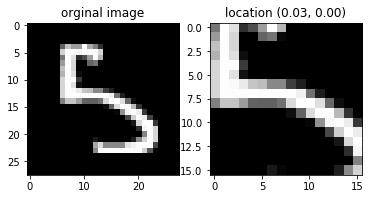

In [62]:
plt.subplot(1, 2, 1)
plt.imshow(imgs[0][:, :, 0], cmap="gray")
plt.title("orginal image")
plt.subplot(1, 2, 2)
plt.imshow(images_glimpse0_[0][:, :, 0], cmap="gray")
plt.title("location (%.2f, %.2f)" %tuple(l0_[0]))
